## Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from glob import glob
import html2text
import datetime
from wordcloud import WordCloud
from scipy import interpolate

In [2]:
# load data
filenames = glob("data/interim/df_*.csv")
dataframes = [pd.read_csv(f, encoding='latin-1') for f in filenames]

In [3]:
for i in range(17):
    dataframes[i] = dataframes[i].drop('Unnamed: 0', axis=1)

### Useful Functions

In [4]:
# takes a post id and returns a dataframe with that post
def getPost(id):
    
    # define dataframe structure in memory
    df = pd.DataFrame(columns=['by', 'score', 'time', 'timestamp', 'title', 'type', 'url', 'text',
       'parent', 'deleted', 'dead', 'descendants', 'id', 'ranking'])
    
    # find the post and add it to the dataframe in memory
    for dataframe in dataframes:
        df = pd.concat([dataframe[dataframe["id"] == id], df])
        
    return df

In [5]:
# takes a list of post ids and returns the comments on those posts
def getComments(parents, family=None):
    
    # define dataframe structure in memory
    children = pd.DataFrame(columns=['by', 'score', 'time', 'timestamp', 'title', 'type', 'url', 'text',
       'parent', 'deleted', 'dead', 'descendants', 'id', 'ranking'])
    
    # store family
    fam = family
    
    # base case: if no parents provided, return the family
    if not parents:
        return fam
    
    # recursive case: if parents provided, add children to family and check next generation
    else:
        
        # define the next generation
        nextgen = []
        
        # for each dataframe
        for dataframe in dataframes:

            # add the parent's children to the next generation
            children = pd.concat([dataframe[dataframe["parent"].isin(parents)], children]) 
            nextgen += list(children["id"])

            # add the parent's children to the family
            fam = pd.concat([children, fam])

            # reset children for the next parent
            children = pd.DataFrame(columns=['by', 'score', 'time', 'timestamp', 'title', 'type', 'url', 'text',
   'parent', 'deleted', 'dead', 'descendants', 'id', 'ranking'])

        # return getThread on the next generation and current family
        return getComments(nextgen, fam)        

In [6]:
def getThread(id):
    return pd.concat([getPost(id), getComments([id])])

In [7]:
def makeDocument(id):
    return html2text.html2text(" ".join(list(getThread(id)["text"].dropna())))

In [8]:
def imputeDescendants(thread):
    thread = thread.reset_index(drop=True)
    
    thread["count"] = 1
    
    sums = thread.groupby("parent").sum().reset_index()[["parent", "count"]]
    
    descendants = pd.merge(thread, sums, how="left", left_on="id", right_on="parent")
    
    descendants = descendants["count_y"].fillna(0).astype(int)
    
    thread["descendants"] = descendants
    
    return thread

In [9]:
def getMostRecentPostsBy(user):
    url = "https://hacker-news.firebaseio.com/v0/user/" + user + ".json"
    response = requests.get(url, data=data)
    comments = response.json()["submitted"][0:3]
    
    posts = []
    
    for comment in comments:
        url = "https://hacker-news.firebaseio.com/v0/item/" + str(comment) + ".json"
        response = requests.get(url, data=data)
        posts += [response.json()["text"]]
        
    return posts

### Establish Time Bounds

In [10]:
months = [datetime.datetime(2006, 11, 1, 0, 0), datetime.datetime(2006, 12, 1, 0, 0)]
for year in range(2007,2018):
    for month in range(1, 13):
        months.append(datetime.datetime(year, month, 1, 0, 0))
months += [datetime.datetime(2018, 1, 1, 0, 0), datetime.datetime(2018, 2, 1, 0, 0)]

months = [month.timestamp() for month in months]

In [11]:
years = [datetime.datetime(year, 1, 1, 0, 0).timestamp() for year in range(2007, 2019)]

### Monthly Active Users

In [12]:
mau = []

for month in months:
    monthPosters = set()

    for dataframe in dataframes:
        monthPosters.update(set(dataframe[((dataframe["time"] < month) & ((dataframe["time"] >= (month - 2595600.0))))]["by"]))
    
    mau.append(len(monthPosters))
    monthPosters = set()

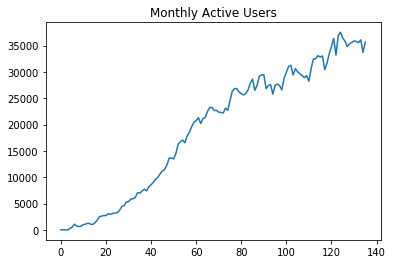

In [13]:
plt.plot(mau)
plt.title("Monthly Active Users")
plt.show()

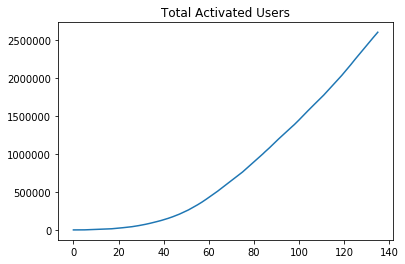

In [14]:
plt.plot(np.cumsum(mau))
plt.title("Total Activated Users")
plt.show()

### Monthly new Stories

In [15]:
storiesInMonth = []

for month in months:
    monthStories = set()

    for dataframe in dataframes:
        monthStories.update(set(dataframe[((dataframe["type"] == "story") & (dataframe["time"] < month) & (dataframe["time"] >= (month - 2595600.0)))]["id"]))
    
    storiesInMonth.append(len(monthStories))
    monthStories = set()

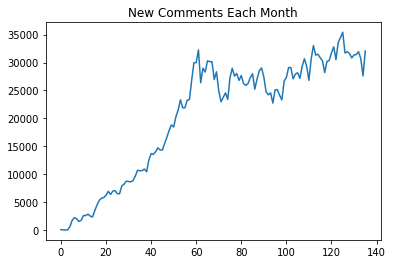

In [16]:
plt.plot(storiesInMonth)
plt.title("New Comments Each Month")
plt.show()

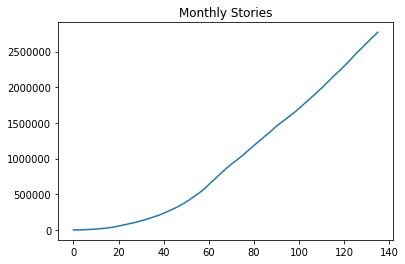

In [17]:
plt.plot(np.cumsum(storiesInMonth))
plt.title("Monthly Stories")
plt.show()

### Monthly new Comments

In [18]:
commentsInMonth = []

for month in months:
    monthComments = set()

    for dataframe in dataframes:
        monthComments.update(set(dataframe[((dataframe["type"] == "comment") & (dataframe["time"] < month) & (dataframe["time"] >= (month - 2595600.0)))]["id"]))
    
    commentsInMonth.append(len(monthComments))
    monthComments = set()

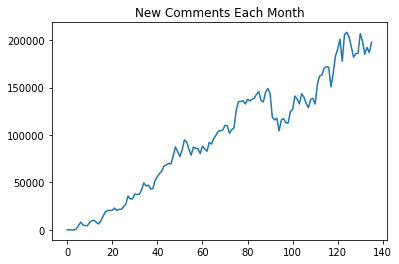

In [19]:
plt.plot(commentsInMonth)
plt.title("New Comments Each Month")
plt.show()

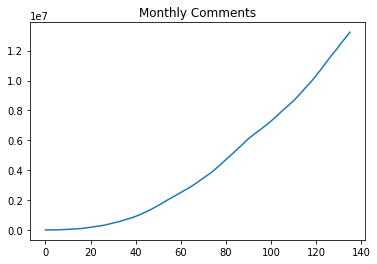

In [20]:
plt.plot(np.cumsum(commentsInMonth))
plt.title("Monthly Comments")

plt.show()

### Users, Stories, and Comments

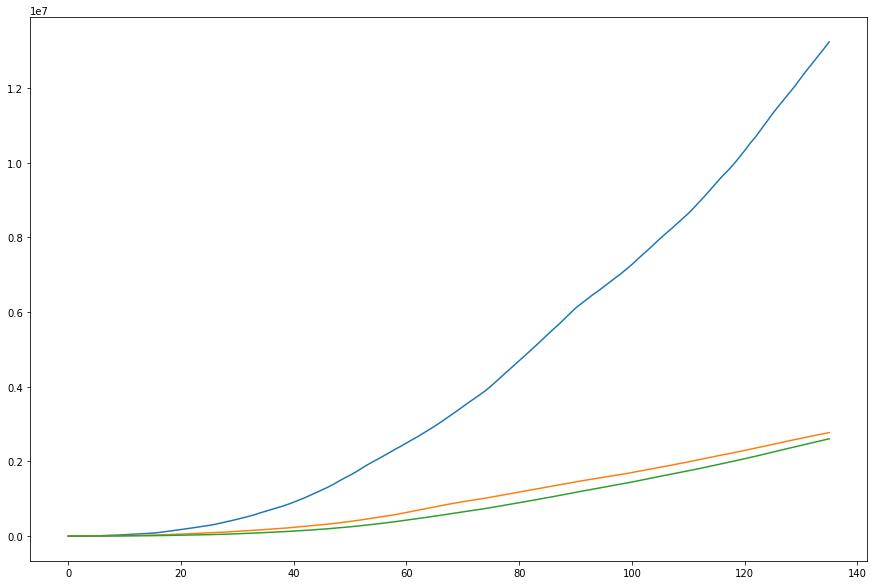

In [21]:
plt.figure(figsize=(15,10))

plt.plot(np.cumsum(commentsInMonth))
plt.plot(np.cumsum(storiesInMonth))
plt.plot(np.cumsum(mau))

plt.show()

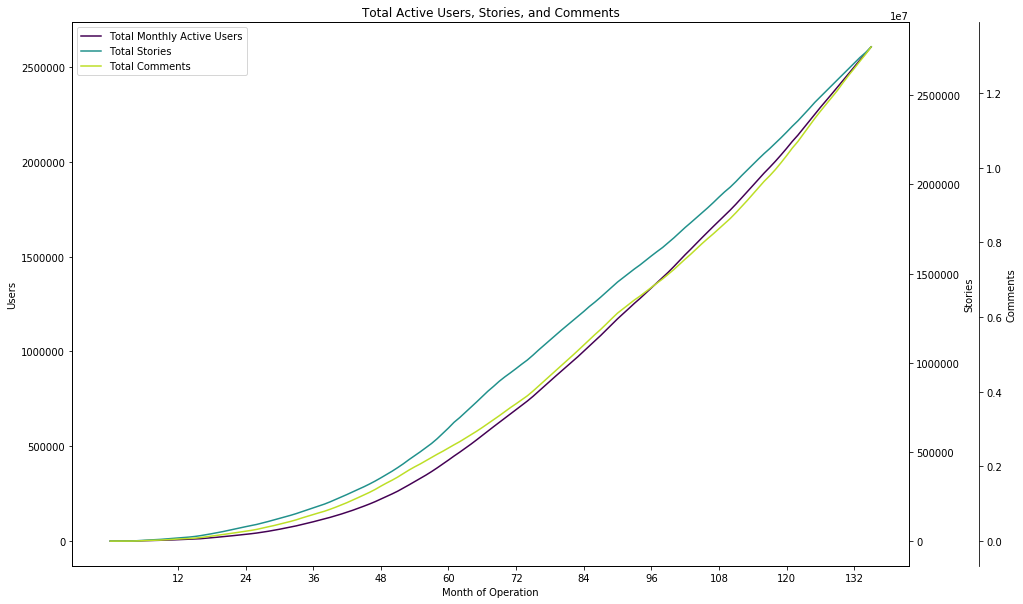

In [28]:
fig = plt.figure(figsize=(15,10))

host = fig.add_subplot(111)

par1 = host.twinx()
par2 = host.twinx()


host.set_xlabel("Month of Operation")
host.set_ylabel("Users")
par1.set_ylabel("Stories")
par2.set_ylabel("Comments")

color1 = plt.cm.viridis(0)
color2 = plt.cm.viridis(0.5)
color3 = plt.cm.viridis(.9)

p1, = host.plot(np.cumsum(mau), color=color1, label="Total Monthly Active Users")
p2, = par1.plot(np.cumsum(storiesInMonth), color=color2, label="Total Stories")
p3, = par2.plot(np.cumsum(commentsInMonth), color=color3, label="Total Comments")

lns = [p1, p2, p3]
host.legend(handles=lns, loc='best')

# right, left, top, bottom
par2.spines['right'].set_position(('outward', 70))      
# no x-ticks                 
par2.xaxis.set_ticks([i*12 for i in range(1,12)])

plt.title("Total Active Users, Stories, and Comments")
plt.show()

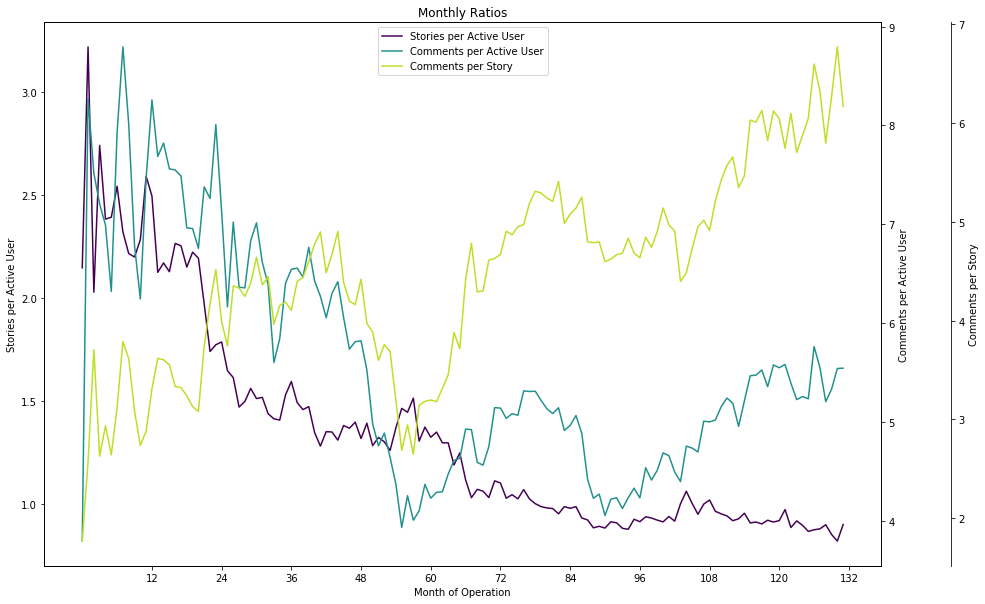

In [29]:
storiesPerUser = np.array(storiesInMonth[4:]) / np.array(mau[4:])
commentsPerUser = np.array(commentsInMonth[4:]) / np.array(mau[4:])
commentsPerStory = np.array(commentsInMonth[4:]) / np.array(storiesInMonth[4:])

fig = plt.figure(figsize=(15,10))

host = fig.add_subplot(111)

par1 = host.twinx()
par2 = host.twinx()


host.set_xlabel("Month of Operation")
host.set_ylabel("Stories per Active User")
par1.set_ylabel("Comments per Active User")
par2.set_ylabel("Comments per Story")


p1, = host.plot(storiesPerUser, color=color1,label="Stories per Active User")
p2, = par1.plot(commentsPerUser, color=color2, label="Comments per Active User")
p3, = par2.plot(commentsPerStory, color=color3, label="Comments per Story")

lns = [p1, p2, p3]
host.legend(handles=lns, loc='upper center')

# right, left, top, bottom
par2.spines['right'].set_position(('outward', 70))      
# no x-ticks                 
par2.xaxis.set_ticks([i*12 for i in range(1,12)])

plt.title("Monthly Ratios")
plt.show()

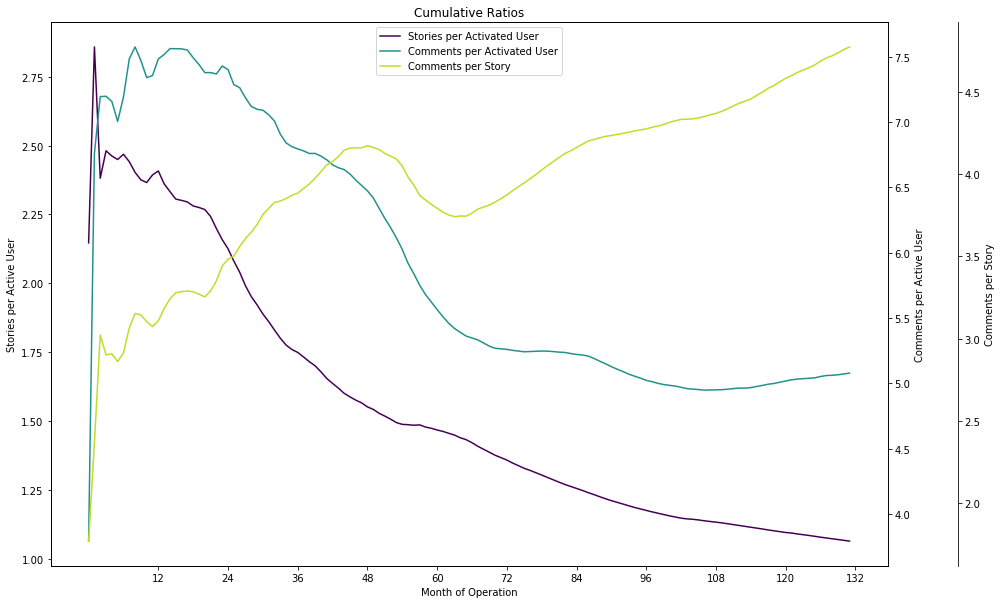

In [30]:
storiesPerUser = np.array(np.cumsum(storiesInMonth[4:])) / np.array(np.cumsum(mau[4:]))
commentsPerUser = np.array(np.cumsum(commentsInMonth[4:])) / np.array(np.cumsum(mau[4:]))
commentsPerStory = np.array(np.cumsum(commentsInMonth[4:])) / np.array(np.cumsum(storiesInMonth[4:]))

fig = plt.figure(figsize=(15,10))

host = fig.add_subplot(111)

par1 = host.twinx()
par2 = host.twinx()


host.set_xlabel("Month of Operation")
host.set_ylabel("Stories per Active User")
par1.set_ylabel("Comments per Active User")
par2.set_ylabel("Comments per Story")


p1, = host.plot(storiesPerUser, color=color1,label="Stories per Activated User")
p2, = par1.plot(commentsPerUser, color=color2, label="Comments per Activated User")
p3, = par2.plot(commentsPerStory, color=color3, label="Comments per Story")

lns = [p1, p2, p3]
host.legend(handles=lns, loc='upper center')

# right, left, top, bottom
par2.spines['right'].set_position(('outward', 70))      
# no x-ticks                 
par2.xaxis.set_ticks([i*12 for i in range(1,12)])

plt.title("Cumulative Ratios")
plt.show()

### Top Stories Each Year

In [31]:
top_stories = []

for year in years:
    
    year_df = pd.DataFrame(columns=['by', 'score', 'time', 'timestamp', 'title', 'type', 'url', 'text',
           'parent', 'deleted', 'dead', 'descendants', 'id', 'ranking'])

    previousYear = year - 31536000
    
    for dataframe in dataframes:
        year_df = pd.concat([year_df, dataframe[((dataframe["type"] == "story") & (dataframe["time"] < year) & (dataframe["time"] > previousYear))]])
        
    year_df = year_df.sort_values(by="score", ascending=False)[0:3]

    top_stories.append(year_df)

In [32]:
for topstories in top_stories[1:]:
    print(datetime.datetime.fromtimestamp(int(list(topstories["time"])[0])).year)
    print("\n")
    print(list(topstories["title"])[0])
    print(list(topstories["title"])[1])
    print(list(topstories["title"])[2])
    print("\n")

2007


Please tell us what features you'd like in news.ycombinator
Number of founders - statistics
Finally, voting without refresh


2008


Startup Ideas We'd Like to Fund
Why to Start a Startup in a Bad Economy
Love, Internet Style


2009


How I Hacked Hacker News (with arc security advisory)
Apple's Mistake
A terrible tragedy: Dan Haubert of Ticketstumbler (fallentimes) has passed away


2010


Introducing Word Lens
Today you, tomorrow me
A new approach to China


2011


Steve Jobs has passed away.
Watch a VC use my name to sell a con
Rob Pike: Dennis Ritchie has died


2012


Show HN: This up votes itself
Request for Startups: Kill Hollywood.
$1B of TSA Nude Body Scanners Made Worthless By Blog


2013


Don't Fly During Ramadan
Hyperloop
Aaron Swartz commits suicide


2014


Tim Cook Speaks Up
2048
Microsoft takes .NET open source and cross-platform


2015


G is for Google
Email Encryption Software Relies on One Guy, Who Is Going Broke
14-Year-Old Boy Arrested for Bringing Homemad

### Descriptive Words of The Annual Top Stories

In [33]:
topStoryIDs = []
for df in top_stories:
    topStoryIDs += list(df["id"])

In [34]:
corpus = [makeDocument(id) for id in topStoryIDs]

In [35]:
text = ""

# find our most descriptive words!
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(corpus)
feature_names = tf.get_feature_names()
dense_matrix = tfidf_matrix.todense()
num_documents = len(corpus)
for i in np.arange(num_documents):
    document_words = dense_matrix[i].tolist()[0]
    document_scores = [pair for pair in zip(range(0, len(document_words)), document_words) if pair[1] > 0]
    
    sorted_scores = sorted(document_scores, key=lambda t: t[1] * -1)[0:5] #5 words
    
    print("Top words in document {}".format(i + 1))
    for scores_tuple in sorted_scores:
        text += " " + str(feature_names[scores_tuple[0]])
        print("\tWord: {}, TF-IDF: {}".format(feature_names[scores_tuple[0]], round(scores_tuple[1], 5)))
        


Top words in document 1
	Word: items, TF-IDF: 0.25157
	Word: comments, TF-IDF: 0.23061
	Word: yc, TF-IDF: 0.21951
	Word: posts, TF-IDF: 0.21155
	Word: lisp, TF-IDF: 0.20529
Top words in document 2
	Word: nice, TF-IDF: 0.72598
	Word: things, TF-IDF: 0.68772
Top words in document 3
	Word: iceberg, TF-IDF: 0.50972
	Word: ui, TF-IDF: 0.27615
	Word: pixels, TF-IDF: 0.25486
	Word: powerpoint, TF-IDF: 0.25486
	Word: underwater, TF-IDF: 0.25486
Top words in document 4
	Word: asics, TF-IDF: 0.42973
	Word: page, TF-IDF: 0.23371
	Word: comments, TF-IDF: 0.22692
	Word: com, TF-IDF: 0.19655
	Word: like, TF-IDF: 0.17773
Top words in document 5
	Word: founders, TF-IDF: 0.40577
	Word: founder, TF-IDF: 0.32123
	Word: companies, TF-IDF: 0.28541
	Word: salesforce, TF-IDF: 0.19629
	Word: harris, TF-IDF: 0.13086
Top words in document 6
	Word: just, TF-IDF: 0.18733
	Word: update, TF-IDF: 0.17831
	Word: accelerator, TF-IDF: 0.17281
	Word: ping, TF-IDF: 0.17281
	Word: href, TF-IDF: 0.16178
Top words in docume

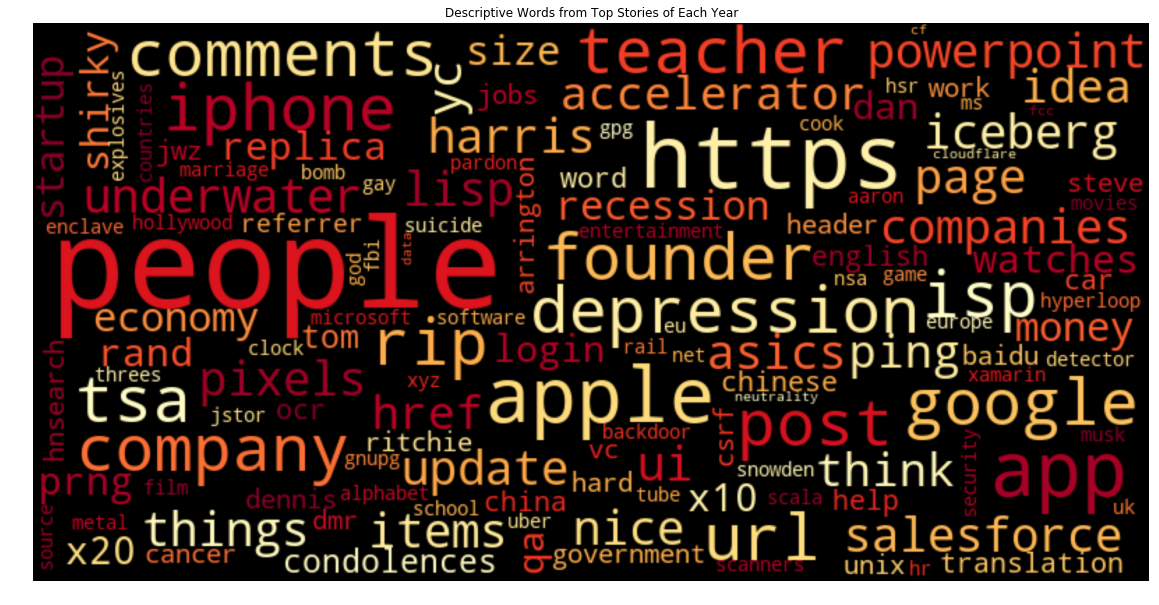

In [36]:
# Generate a word cloud image
wordcloud = WordCloud(width=800, height=400, max_font_size=90, colormap="YlOrRd").generate(text)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation="gaussian")
plt.axis("off")
plt.title("Descriptive Words from Top Stories of Each Year")
plt.show()

### Keyword Appearances

In [37]:
## Calculating amount of fucks given
df = pd.DataFrame(columns=['by', 'score', 'time', 'timestamp', 'title', 'type', 'url', 'text',
           'parent', 'deleted', 'dead', 'descendants', 'id', 'ranking'])

for dataframe in dataframes:
    keyword_df = dataframe[dataframe.text.str.contains("fuck").fillna(False)]
    df = pd.concat([df, keyword_df])

    
fucksGivenByMonth = []

for month in months:
    monthFucks = set()

    monthFucks.update(set(df[((df["type"] == "comment") & (df["time"] < month))]["id"]))
    
    fucksGivenByMonth.append(len(monthFucks))
    monthFucks = set()

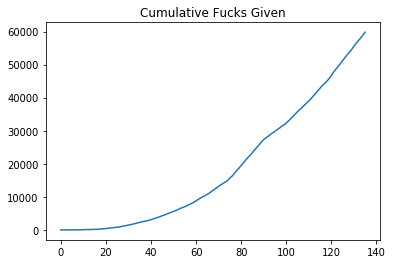

In [38]:
plt.plot(fucksGivenByMonth)
plt.title("Cumulative Fucks Given")
plt.show()

In [39]:
## Calculating amount of fucks given
df = pd.DataFrame(columns=['by', 'score', 'time', 'timestamp', 'title', 'type', 'url', 'text',
           'parent', 'deleted', 'dead', 'descendants', 'id', 'ranking'])

for dataframe in dataframes:
    keyword_df = dataframe[dataframe.text.str.contains("fuck").fillna(False)]
    df = pd.concat([df, keyword_df])

    
fucksGivenByMonth = []

for month in months:
    monthFucks = set()

    monthFucks.update(set(df[((df["type"] == "comment") & (df["time"] < month) & (df["time"] >= (month - 2595600.0)))]["id"]))
    
    fucksGivenByMonth.append(len(monthFucks))
    monthFucks = set()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


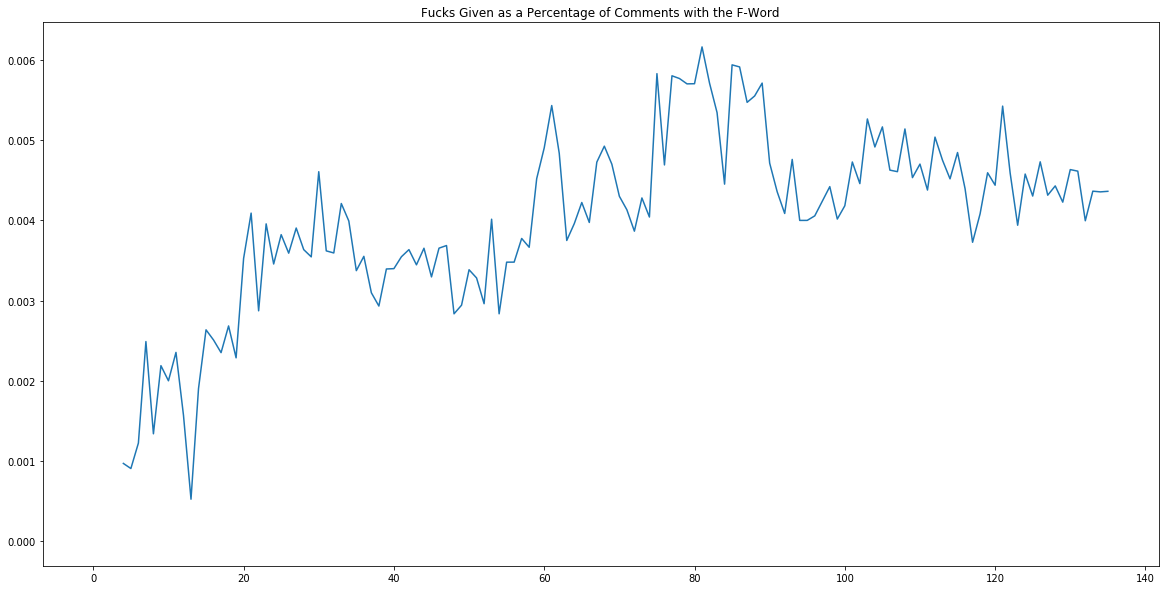

In [40]:
plt.figure(figsize=(20,10))
plt.plot(np.array(fucksGivenByMonth)/np.array(commentsInMonth))
plt.title("Fucks Given as a Percentage of Comments with the F-Word")
plt.show()

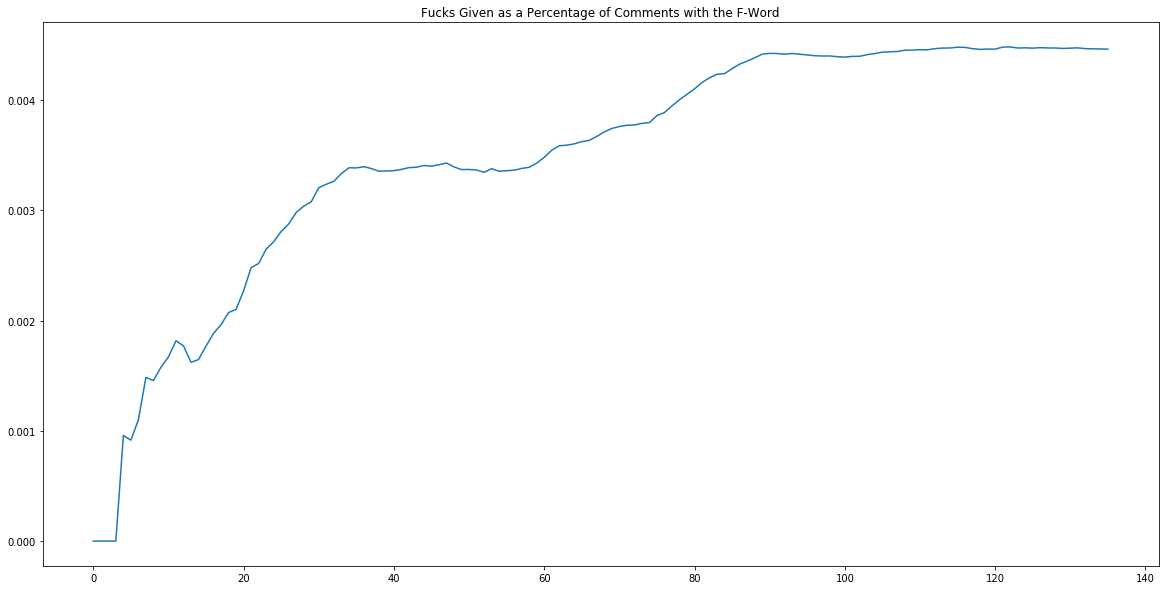

In [41]:
plt.figure(figsize=(20,10))
plt.plot(np.array(np.cumsum(fucksGivenByMonth))/np.array(np.cumsum(commentsInMonth)))
plt.title("Fucks Given as a Percentage of Comments with the F-Word")
plt.show()

In [42]:
hype = ["web 2.0", "ipv6", "gesture", "3d printing", "mobile social", "prediction market", "cloud", "e-book", "activity stream", "3d tv", "internet tv", "nfc", "byod", "gamification", "crowdsourcing", "iot", "natural language", "autonomous", "wearable", "machine learning", "blockchain", "deep learning", "connected home"]

In [43]:
hypeframes = []

for hypeword in hype:
    df = pd.DataFrame(columns=['by', 'score', 'time', 'timestamp', 'title', 'type', 'url', 'text',
           'parent', 'deleted', 'dead', 'descendants', 'id', 'ranking'])
    
    for dataframe in dataframes:
        keyword_df = dataframe[dataframe.text.str.contains(hypeword).fillna(False)]
        df = pd.concat([df, keyword_df])
        
    hypeframes.append(df)
    
    
hypeWordSeries = []

for df in hypeframes:
    keywordByMonth = []
    for month in months:
        monthWords = set()

        monthWords.update(set(df[((df["type"] == "comment") & (df["time"] < month) & (df["time"] >= (month - 2595600.0)))]["id"]))

        keywordByMonth.append(len(monthWords))
        monthWords = set()
    hypeWordSeries.append(keywordByMonth)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


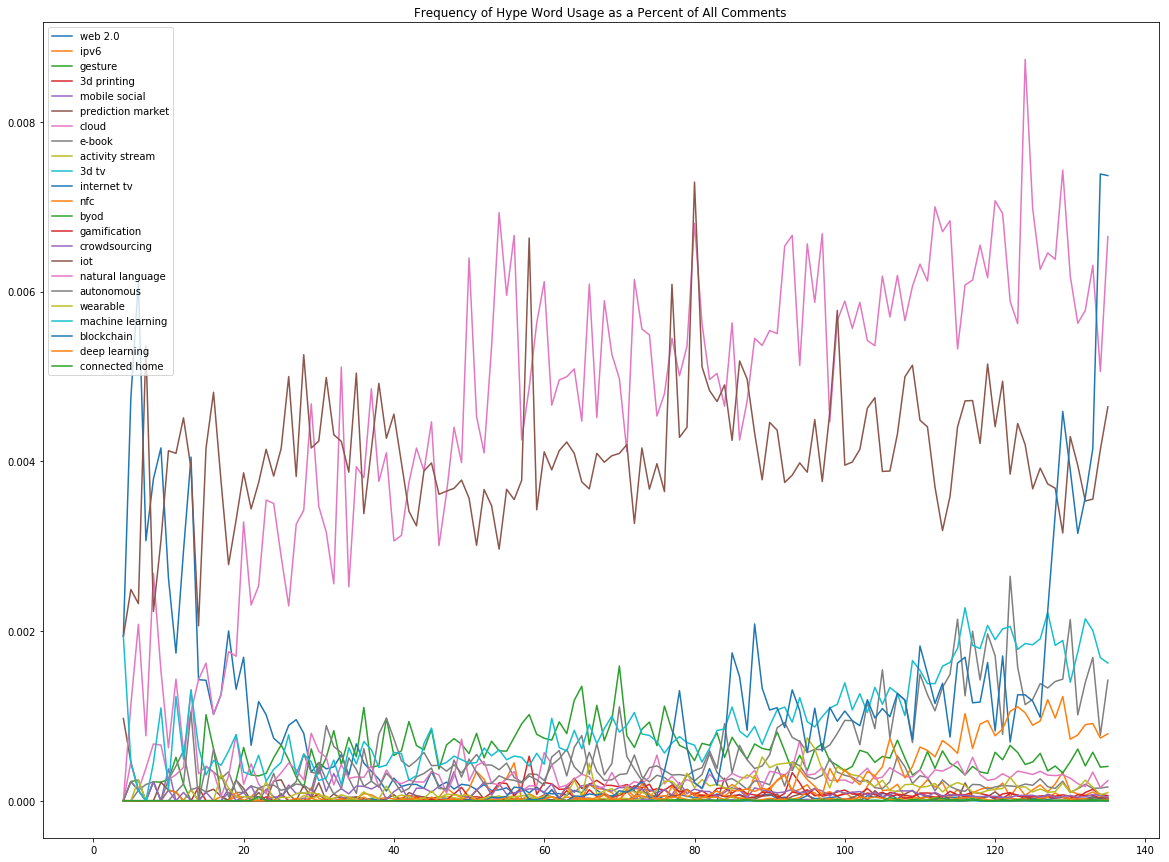

In [44]:
plt.figure(figsize=(20,15))

for hypeword, label in zip(hypeWordSeries, hype):
    plt.plot((np.array(hypeword)/np.array(commentsInMonth)), label=label)

plt.legend()
plt.title("Frequency of Hype Word Usage as a Percent of All Comments")
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  # This is added back by InteractiveShellApp.init_path()


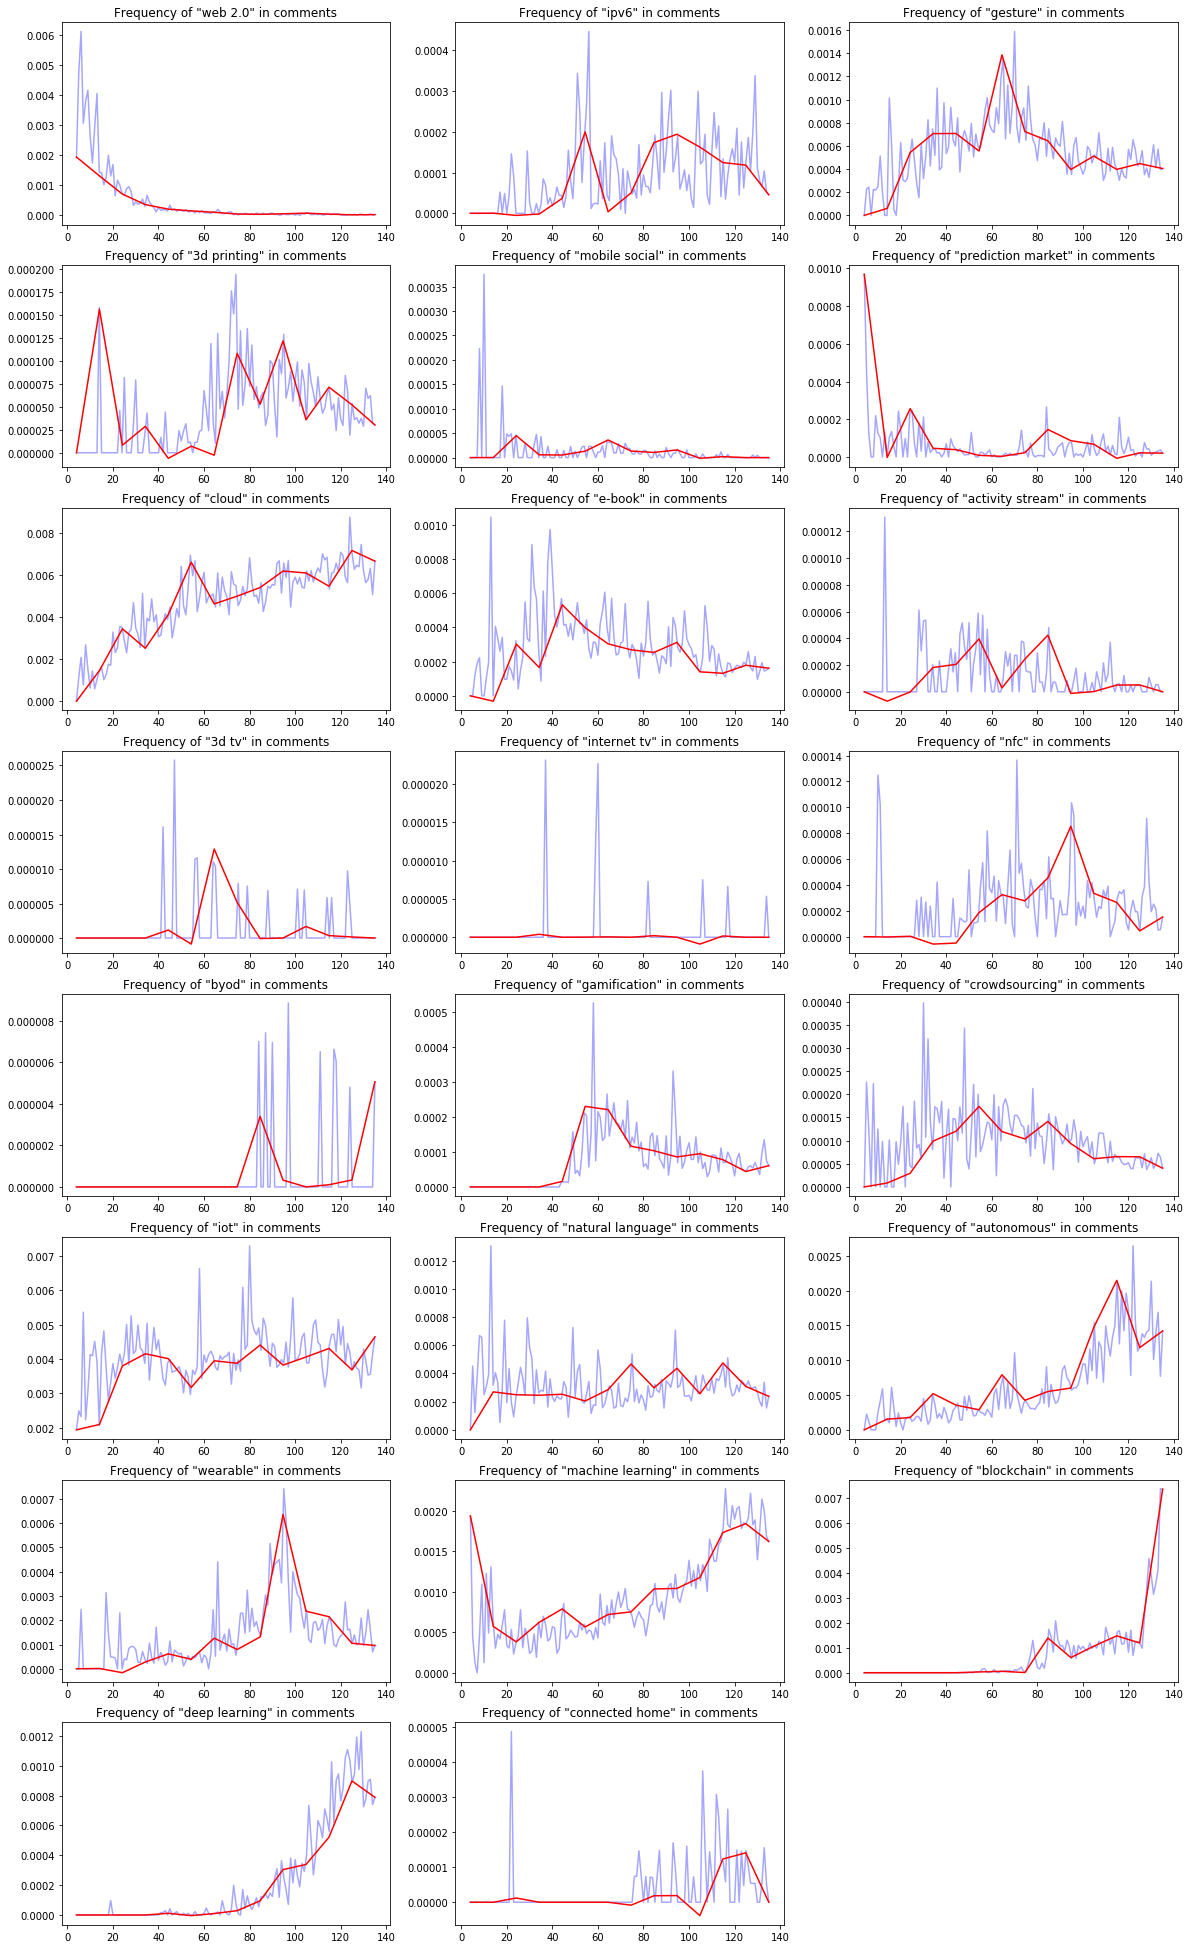

In [45]:
plt.figure(figsize=(20,35))
for hypeword, label, n in zip(hypeWordSeries, hype, range(1,24)):
    
    plt.subplot(8,3,n)
    plt.title("Frequency of \"" + str(label) + "\" in comments")
    
    x = np.array(range(len(hypeword)))[4:]
    y = np.array(hypeword[4:])/np.array(commentsInMonth[4:])
    
    x_smooth = np.linspace(x.min(), x.max(), 14)
    y_smooth = interpolate.spline(x, y, x_smooth)
    
    plt.plot(x, y, "blue", alpha=0.35)
    plt.plot(x_smooth, y_smooth, "red")

plt.show()